In [10]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils import load_anything, get_basename, path_of, norm, float_to_uint16, care_align, quantile_image, quantile_image_minmax, hill, mip, upsample3d, iou, iou_cuda, get_best_iou
import tifffile
import torch
import torch.nn.functional as F

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from tqdm import tqdm

In [11]:
base = "_results_for_paper"

# fig. 4 beads data

In [12]:
idx = 3

tenet         = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603", idx))[0]
tenet_no_ewc  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_623", idx))[0]
tenet_no_psf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_624", idx))[0]
tenet_no_vq   = tifffile.imread(path_of(base, "fig4", "tenet/JNet_625", idx))[0]
tenet_x2_ewc  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_626", idx))[0]
tenet_x2_psf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_627", idx))[0]
tenet_x2_vq   = tifffile.imread(path_of(base, "fig4", "tenet/JNet_628", idx))[0]
tenet_x1_mrf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_629", idx))[0]
tenet_gauss_psf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_630", idx))[0]

In [13]:
print("tenet      ", tenet     .shape) 

tenet       (240, 128, 128)


In [14]:
rois = [
    {'image': 0,  'zmid': 15, 'xmid': 342, 'ymid': 299, 'model_id':0},
    {'image': 4,  'zmid': 12, 'xmid': 262, 'ymid': 252, 'model_id':0},
    {'image': 5,  'zmid': 13, 'xmid': 199, 'ymid': 291, 'model_id':0},
    {'image': 6,  'zmid': 12, 'xmid': 238, 'ymid': 268, 'model_id':1},
    {'image': 6,  'zmid': 12, 'xmid': 342, 'ymid': 150, 'model_id':1},
    {'image': 7,  'zmid': 12, 'xmid': 278, 'ymid': 205, 'model_id':1},
    {'image': 8,  'zmid': 12, 'xmid': 290, 'ymid': 219, 'model_id':2},
    {'image': 9,  'zmid': 12, 'xmid': 273, 'ymid': 235, 'model_id':2},
    {'image': 10, 'zmid': 12, 'xmid': 286, 'ymid': 224, 'model_id':2},
    {'image': 11, 'zmid': 13, 'xmid': 323, 'ymid': 231, 'model_id':3},
    {'image': 12, 'zmid': 13, 'xmid': 296, 'ymid': 202, 'model_id':3},
    {'image': 13, 'zmid': 13, 'xmid': 293, 'ymid': 244, 'model_id':3},
    {'image': 14, 'zmid': 17, 'xmid': 249, 'ymid': 190, 'model_id':4},
    {'image': 15, 'zmid': 12, 'xmid': 246, 'ymid': 254, 'model_id':4},
    {'image': 16, 'zmid': 12, 'xmid': 272, 'ymid': 225, 'model_id':4},
    {'image': 17, 'zmid': 12, 'xmid': 298, 'ymid': 224, 'model_id':5},
    {'image': 18, 'zmid': 12, 'xmid': 288, 'ymid': 215, 'model_id':5},
    {'image': 18, 'zmid': 12, 'xmid': 275, 'ymid': 442, 'model_id':5},
    {'image': 22, 'zmid': 17, 'xmid': 286, 'ymid': 221, 'model_id':6},
    {'image': 23, 'zmid': 17, 'xmid': 254, 'ymid': 256, 'model_id':6},
    {'image': 24, 'zmid': 17, 'xmid': 258, 'ymid': 283, 'model_id':6},
    {'image': 26, 'zmid': 17, 'xmid': 159, 'ymid': 285, 'model_id':7},
    {'image': 27, 'zmid': 16, 'xmid': 233, 'ymid': 201, 'model_id':7},
    {'image': 28, 'zmid': 15, 'xmid': 345, 'ymid': 119, 'model_id':7},
    {'image': 28, 'zmid': 16, 'xmid': 236, 'ymid': 285, 'model_id':8},
    {'image': 28, 'zmid': 16, 'xmid': 236, 'ymid': 285, 'model_id':8},
    {'image': 29, 'zmid': 15, 'xmid': 341, 'ymid': 147, 'model_id':8},
    {'image': 29, 'zmid': 15, 'xmid': 277, 'ymid': 274, 'model_id':9},
    {'image': 30, 'zmid': 16, 'xmid': 144, 'ymid': 306, 'model_id':9},
    {'image': 30, 'zmid': 15, 'xmid': 422, 'ymid': 421, 'model_id':9}
    ]



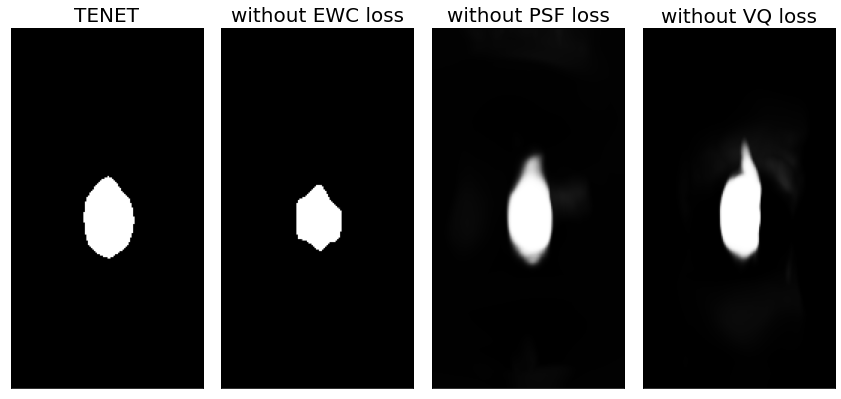

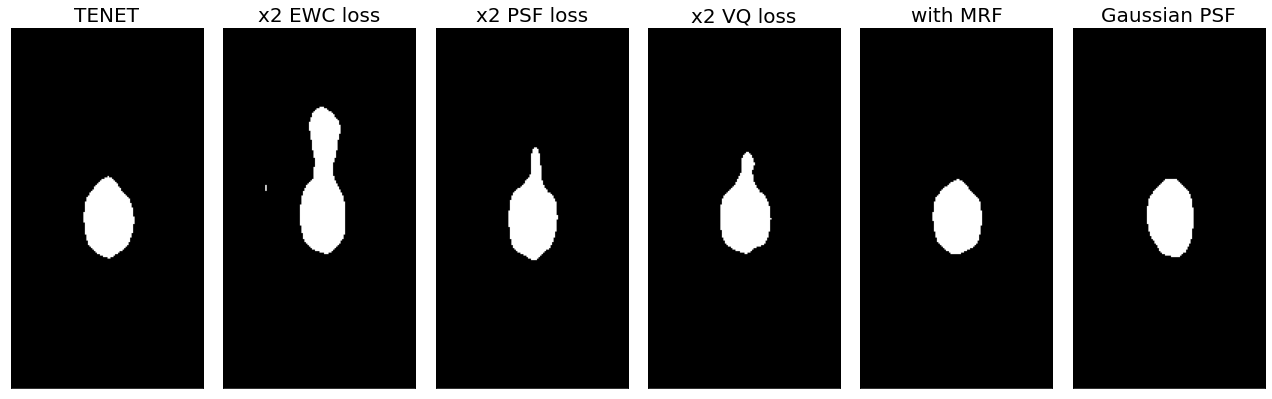

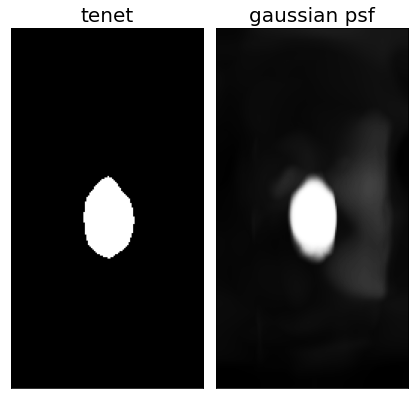

In [26]:
def figure_4a(figures  ,
               sec     ,
               start   ,
               range   ,
               x_start  ,
               x_end    ,
               y_start  ,
               y_end    ,
               figsize  ,
               fontsize ,
               figname  ,
               ):
    fig = plt.figure(figsize=figsize)
    fig.set_facecolor('white')
    ylabels = ["",]
    gs = gridspec.GridSpec(3, len(figures), figure=fig, wspace=0)
    for i, figure in enumerate(figures):
        for j, img in enumerate(figure[0]):
            ax = fig.add_subplot(gs[j, i])
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_title(label=figure[1], fontsize=fontsize)
            
            if i == 0:
                ax.set_ylabel(ylabels[j], fontsize=fontsize)
            
            image_to_show = mip(img        ,
                                sec=sec    ,
                                start=start,
                                range=range,
                                )

            ax.imshow(image_to_show[y_start:y_end, x_start:x_end],
                      cmap="gray")

    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    return fig

idx = 0
tenet         = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603", idx))[0] >0.5
tenet_no_ewc  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_623", idx))[0]
tenet_no_psf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_624", idx))[0]
tenet_no_vq   = tifffile.imread(path_of(base, "fig4", "tenet/JNet_625", idx))[0]
figures = [
    [[tenet         ], "TENET"               ],
    [[tenet_no_ewc  ], "without EWC loss"    ],
    [[tenet_no_psf  ], "without PSF loss"    ],
    [[tenet_no_vq   ], "without VQ loss"     ],
]

# functions to generate
fig4a = figure_4a(
    figures,
    sec="xz",
    start=0,
    range=128,
    x_start=0,
    x_end=128,
    y_start=0,
    y_end=256,
    figsize=(12, 16),
    fontsize=20,
    figname="test",
    )

figures = [
    [[tenet         ], "TENET"               ],
    [[tenet_no_ewc  ], "without EWC loss"    ],
    [[tenet_no_psf  ], "without PSF loss"    ],
    [[tenet_no_vq   ], "without VQ loss"     ],
]


tenet_x2_ewc   = tifffile.imread(path_of(base, "fig4", "tenet/JNet_626", idx))[0] >0.5
tenet_x2_psf   = tifffile.imread(path_of(base, "fig4", "tenet/JNet_627", idx))[0] >0.5
tenet_x2_vq    = tifffile.imread(path_of(base, "fig4", "tenet/JNet_628", idx))[0] >0.5
tenet_x1_mrf   = tifffile.imread(path_of(base, "fig4", "tenet/JNet_629", idx))[0] >0.5
tenet_gauss_psf= tifffile.imread(path_of(base, "fig4", "tenet/JNet_630", idx))[0] >0.5

figures =  [[[tenet],"TENET",],
            [[tenet_x2_ewc], "x2 EWC loss",] ,
            [[tenet_x2_psf], "x2 PSF loss",] ,
            [[tenet_x2_vq ], "x2 VQ loss", ],
            [[tenet_x1_mrf], "with MRF", ],
            [[tenet_gauss_psf], "Gaussian PSF", ],
            ]

fig4a = figure_4a(
    figures,
    sec="xz",
    start=0,
    range=128,
    x_start=0,
    x_end=128,
    y_start=0,
    y_end=256,
    figsize=(18, 16),
    fontsize=20,
    figname="test",
    )

tenet_gauss_psf= tifffile.imread(path_of(base, "fig4", "tenet/JNet_630", idx))[0] 

figures =  [[[tenet],"tenet",],
            [[tenet_gauss_psf], "gaussian psf", ],
            ]

fig4a = figure_4a(
    figures,
    sec="xz",
    start=0,
    range=128,
    x_start=0,
    x_end=128,
    y_start=0,
    y_end=256,
    figsize=(6, 16),
    fontsize=20,
    figname="test",
    )

In [16]:
from skimage.measure import marching_cubes, mesh_surface_area

def sphericity(arr, threshold):
    verts, faces, _, _ = marching_cubes(arr, threshold)
    surface = mesh_surface_area(verts, faces)
    volume  = np.sum(arr>threshold)
    return pow(np.pi, 1/3) * pow(6 * volume, 2/3) / surface # Sphericity by wadell, 1935

#sphericity(tenet, 0.5)

def z_xy_ratio(arr, threshold):
    '''
    arr ; 3d array with dim [z,x,y]
    Calculate the z/xy diameter ratio
    From the slice with maximum xy area, calculate the diameter assuming it is circular
    For z, use the length from the lowest to highest slice containing voxels above the threshold
    '''
    num_z_stack = arr.shape[0]
    lowest  = -1
    highest = -1
    max_area = 0
    for height in range(num_z_stack):
        z_slice = arr[height]
        area = np.sum(z_slice > threshold)
        if area > 0:
            if lowest == -1:
                lowest = height
            highest = height
            
            if area > max_area:
                max_area = area

    z_extent = highest - lowest + 1
    xy_diameter = 2 * np.sqrt(max_area / np.pi)
    return z_extent / xy_diameter

In [9]:

thresholds = np.arange(0.1, 1.0, 0.1)
num_thresholds = len(thresholds)
num_samples = 30

# Initialize storage for metrics
methods = [
        "tenet",
        "without ewc loss", 
        "without psf loss", 
        "without vq loss" , 
        "x2 ewc loss", 
        "x2 psf loss", 
        "x2 vq loss", 
        "x1 mrf", 
        "gaussian psf"]

num_methods = len(methods)

# Storage: [method, threshold, sample]
volumes = np.zeros((num_methods, num_thresholds, num_samples))
sphericities = np.zeros((num_methods, num_thresholds, num_samples))
z_xy_ratios = np.zeros((num_methods, num_thresholds, num_samples))

# Process each sample
for idx in tqdm(range(30)):
    
    # Load images
    tenet         = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603", idx))[0]
    tenet_no_ewc  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_623", idx))[0]
    tenet_no_psf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_624", idx))[0]
    tenet_no_vq   = tifffile.imread(path_of(base, "fig4", "tenet/JNet_625", idx))[0]
    tenet_x2_ewc  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_626", idx))[0]
    tenet_x2_psf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_627", idx))[0]
    tenet_x2_vq   = tifffile.imread(path_of(base, "fig4", "tenet/JNet_628", idx))[0]
    tenet_x1_mrf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_629", idx))[0]
    tenet_gauss_psf  = tifffile.imread(path_of(base, "fig4", "tenet/JNet_630", idx))[0]


    
    images = [
        tenet       ,
        tenet_no_ewc, 
        tenet_no_psf, 
        tenet_no_vq , 
        tenet_x2_ewc, 
        tenet_x2_psf, 
        tenet_x2_vq , 
        tenet_x1_mrf, 
        tenet_gauss_psf
    ]
    
    # Grid search over thresholds
    for method_idx, img in enumerate(images):
        for thresh_idx, threshold in enumerate(thresholds):
            # Calculate volume (in cubic microns)
            volumes[method_idx, thresh_idx, idx] = np.sum((img > threshold) * 0.05 ** 3)
            
            try:
                sphericities[method_idx, thresh_idx, idx] = sphericity(img, threshold)
            except:
                sphericities[method_idx, thresh_idx, idx] = np.nan
            
            try:
                z_xy_ratios[method_idx, thresh_idx, idx] = z_xy_ratio(img, threshold)
            except:
                z_xy_ratios[method_idx, thresh_idx, idx] = np.nan

# Calculate mean and std for each metric
volume_mean = np.nanmean(volumes, axis=2)
volume_std = np.nanstd(volumes, axis=2)

sphericity_mean = np.nanmean(sphericities, axis=2)
sphericity_std = np.nanstd(sphericities, axis=2)

z_xy_ratio_mean = np.nanmean(z_xy_ratios, axis=2)
z_xy_ratio_std = np.nanstd(z_xy_ratios, axis=2)

# Calculate losses
theoretical_volume = 4.187

volume_loss_mean = np.abs((volume_mean - theoretical_volume) / theoretical_volume)
sphericity_loss_mean = np.abs(sphericity_mean - 1)
z_xy_loss_mean = np.abs(z_xy_ratio_mean - 1)
sphe_zxy_loss_mean = z_xy_loss_mean + sphericity_loss_mean
total_loss_mean = volume_loss_mean + sphericity_loss_mean + z_xy_loss_mean

optimal_indices = np.argmin(total_loss_mean, axis=1)
optimal_thresholds = thresholds[optimal_indices]


100%|██████████| 30/30 [01:36<00:00,  3.21s/it]


Ablation study results saved to ablation_study_results.csv
Add loss experiment results saved to add_loss_experiment_results.csv


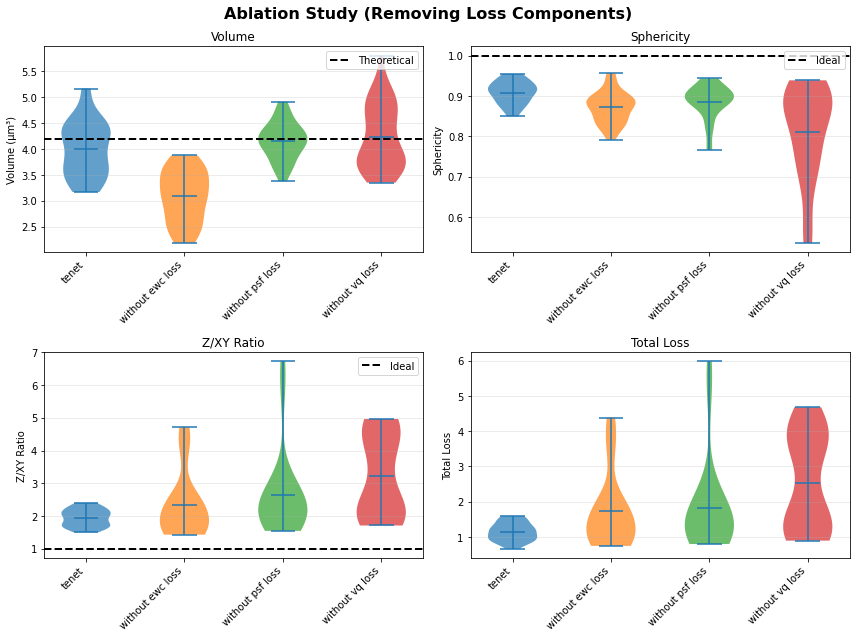

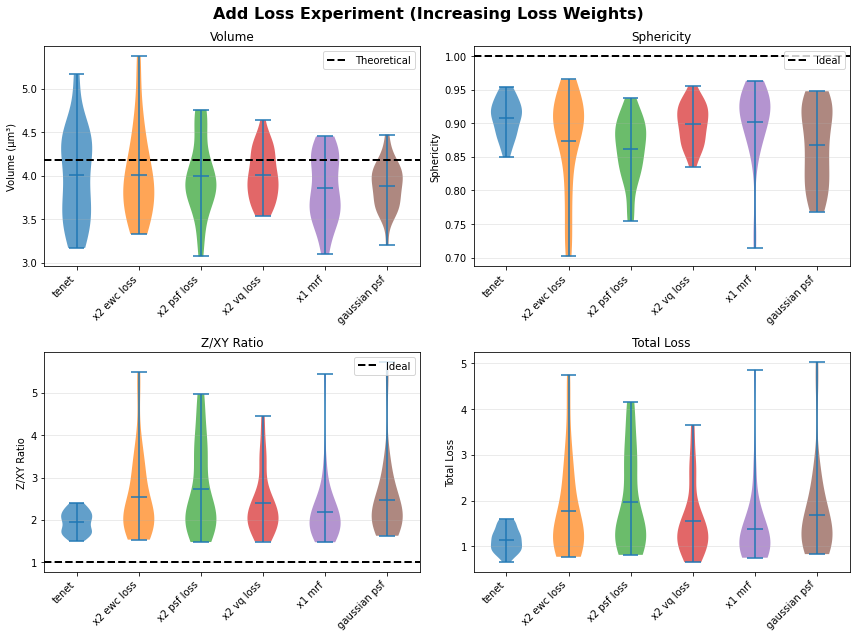

In [17]:
# Prepare data for violin plots at threshold 0.5
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']# Separate methods into two groups

ablation_methods = [
    "tenet",
    "without ewc loss", 
    "without psf loss", 
    "without vq loss"
]

add_loss_methods = [
    "tenet",
    "x2 ewc loss", 
    "x2 psf loss", 
    "x2 vq loss", 
    "x1 mrf",
    "gaussian psf"
]

# Indices for each group
ablation_indices = [0, 1, 2, 3]
add_loss_indices = [0, 4, 5, 6, 7, 8]

fixed_threshold = 0.5
fixed_thresh_idx = np.where(thresholds == fixed_threshold)[0][0]

# Prepare CSV data for ablation study
csv_data_ablation = {
    'Method': [],
    'Sample': [],
    'Volume': [],
    'Sphericity': [],
    'Z/XY Ratio': [],
    'Total Loss': []
}

for method_idx in ablation_indices:
    for sample_idx in range(num_samples):
        csv_data_ablation['Method'].append(methods[method_idx])
        csv_data_ablation['Sample'].append(sample_idx)
        csv_data_ablation['Volume'].append(volumes[method_idx, fixed_thresh_idx, sample_idx])
        csv_data_ablation['Sphericity'].append(sphericities[method_idx, fixed_thresh_idx, sample_idx])
        csv_data_ablation['Z/XY Ratio'].append(z_xy_ratios[method_idx, fixed_thresh_idx, sample_idx])
        
        loss = np.abs((volumes[method_idx, fixed_thresh_idx, sample_idx] - 4.187) / 4.187) + \
               np.abs(sphericities[method_idx, fixed_thresh_idx, sample_idx] - 1) + \
               np.abs(z_xy_ratios[method_idx, fixed_thresh_idx, sample_idx] - 1)
        csv_data_ablation['Total Loss'].append(loss)

df_ablation = pd.DataFrame(csv_data_ablation)
df_ablation.to_csv('ablation_study_results.csv', index=False)
print("Ablation study results saved to ablation_study_results.csv")

# Prepare CSV data for add more loss experiment
csv_data_add_loss = {
    'Method': [],
    'Sample': [],
    'Volume': [],
    'Sphericity': [],
    'Z/XY Ratio': [],
    'Total Loss': []
}

for method_idx in add_loss_indices:
    for sample_idx in range(num_samples):
        csv_data_add_loss['Method'].append(methods[method_idx])
        csv_data_add_loss['Sample'].append(sample_idx)
        csv_data_add_loss['Volume'].append(volumes[method_idx, fixed_thresh_idx, sample_idx])
        csv_data_add_loss['Sphericity'].append(sphericities[method_idx, fixed_thresh_idx, sample_idx])
        csv_data_add_loss['Z/XY Ratio'].append(z_xy_ratios[method_idx, fixed_thresh_idx, sample_idx])
        
        loss = np.abs((volumes[method_idx, fixed_thresh_idx, sample_idx] - 4.187) / 4.187) + \
               np.abs(sphericities[method_idx, fixed_thresh_idx, sample_idx] - 1) + \
               np.abs(z_xy_ratios[method_idx, fixed_thresh_idx, sample_idx] - 1)
        csv_data_add_loss['Total Loss'].append(loss)

df_add_loss = pd.DataFrame(csv_data_add_loss)
df_add_loss.to_csv('add_loss_experiment_results.csv', index=False)
print("Add loss experiment results saved to add_loss_experiment_results.csv")

# Violin plots for Ablation Study
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle('Ablation Study (Removing Loss Components)', fontsize=16, fontweight='bold')

# Volume
violin_data_volume = [volumes[i, fixed_thresh_idx, :] for i in ablation_indices]
parts = axes[0, 0].violinplot(violin_data_volume, positions=range(len(ablation_indices)), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[0, 0].set_xticks(range(len(ablation_indices)))
axes[0, 0].set_xticklabels(ablation_methods, rotation=45, ha='right')
axes[0, 0].set_ylabel('Volume (μm³)')
axes[0, 0].set_title(f'Volume')
axes[0, 0].axhline(y=4.187, color='black', linestyle='--', linewidth=2, label='Theoretical')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Sphericity
violin_data_sphericity = [sphericities[i, fixed_thresh_idx, :] for i in ablation_indices]
parts = axes[0, 1].violinplot(violin_data_sphericity, positions=range(len(ablation_indices)), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[0, 1].set_xticks(range(len(ablation_indices)))
axes[0, 1].set_xticklabels(ablation_methods, rotation=45, ha='right')
axes[0, 1].set_ylabel('Sphericity')
axes[0, 1].set_title(f'Sphericity')
axes[0, 1].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Z/XY Ratio
violin_data_zxy = [z_xy_ratios[i, fixed_thresh_idx, :] for i in ablation_indices]
parts = axes[1, 0].violinplot(violin_data_zxy, positions=range(len(ablation_indices)), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[1, 0].set_xticks(range(len(ablation_indices)))
axes[1, 0].set_xticklabels(ablation_methods, rotation=45, ha='right')
axes[1, 0].set_ylabel('Z/XY Ratio')
axes[1, 0].set_title(f'Z/XY Ratio')
axes[1, 0].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Total Loss
violin_data_total = []
for i in ablation_indices:
    losses = np.abs((volumes[i, fixed_thresh_idx, :] - 4.187) / 4.187) + \
             np.abs(sphericities[i, fixed_thresh_idx, :] - 1) + \
             np.abs(z_xy_ratios[i, fixed_thresh_idx, :] - 1)
    violin_data_total.append(losses)
parts = axes[1, 1].violinplot(violin_data_total, positions=range(len(ablation_indices)), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[1, 1].set_xticks(range(len(ablation_indices)))
axes[1, 1].set_xticklabels(ablation_methods, rotation=45, ha='right')
axes[1, 1].set_ylabel('Total Loss')
axes[1, 1].set_title(f'Total Loss')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ablation_study_violin_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Violin plots for Add Loss Experiment
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle('Add Loss Experiment (Increasing Loss Weights)', fontsize=16, fontweight='bold')

# Volume
violin_data_volume = [volumes[i, fixed_thresh_idx, :] for i in add_loss_indices]
parts = axes[0, 0].violinplot(violin_data_volume, positions=range(len(add_loss_indices)), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[0, 0].set_xticks(range(len(add_loss_indices)))
axes[0, 0].set_xticklabels(add_loss_methods, rotation=45, ha='right')
axes[0, 0].set_ylabel('Volume (μm³)')
axes[0, 0].set_title(f'Volume')
axes[0, 0].axhline(y=4.187, color='black', linestyle='--', linewidth=2, label='Theoretical')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Sphericity
violin_data_sphericity = [sphericities[i, fixed_thresh_idx, :] for i in add_loss_indices]
parts = axes[0, 1].violinplot(violin_data_sphericity, positions=range(len(add_loss_indices)), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[0, 1].set_xticks(range(len(add_loss_indices)))
axes[0, 1].set_xticklabels(add_loss_methods, rotation=45, ha='right')
axes[0, 1].set_ylabel('Sphericity')
axes[0, 1].set_title(f'Sphericity')
axes[0, 1].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Z/XY Ratio
violin_data_zxy = [z_xy_ratios[i, fixed_thresh_idx, :] for i in add_loss_indices]
parts = axes[1, 0].violinplot(violin_data_zxy, positions=range(len(add_loss_indices)), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[1, 0].set_xticks(range(len(add_loss_indices)))
axes[1, 0].set_xticklabels(add_loss_methods, rotation=45, ha='right')
axes[1, 0].set_ylabel('Z/XY Ratio')
axes[1, 0].set_title(f'Z/XY Ratio')
axes[1, 0].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Total Loss
violin_data_total = []
for i in add_loss_indices:
    losses = np.abs((volumes[i, fixed_thresh_idx, :] - 4.187) / 4.187) + \
             np.abs(sphericities[i, fixed_thresh_idx, :] - 1) + \
             np.abs(z_xy_ratios[i, fixed_thresh_idx, :] - 1)
    violin_data_total.append(losses)
parts = axes[1, 1].violinplot(violin_data_total, positions=range(len(add_loss_indices)), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[1, 1].set_xticks(range(len(add_loss_indices)))
axes[1, 1].set_xticklabels(add_loss_methods, rotation=45, ha='right')
axes[1, 1].set_ylabel('Total Loss')
axes[1, 1].set_title(f'Total Loss')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('add_loss_experiment_violin_plots.png', dpi=300, bbox_inches='tight')
plt.show()

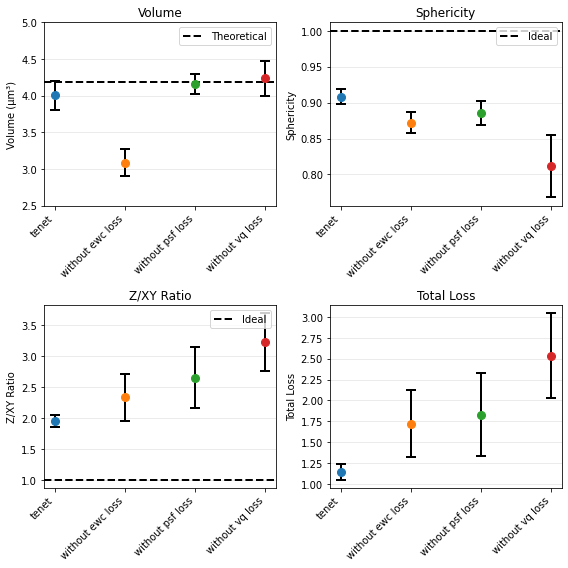

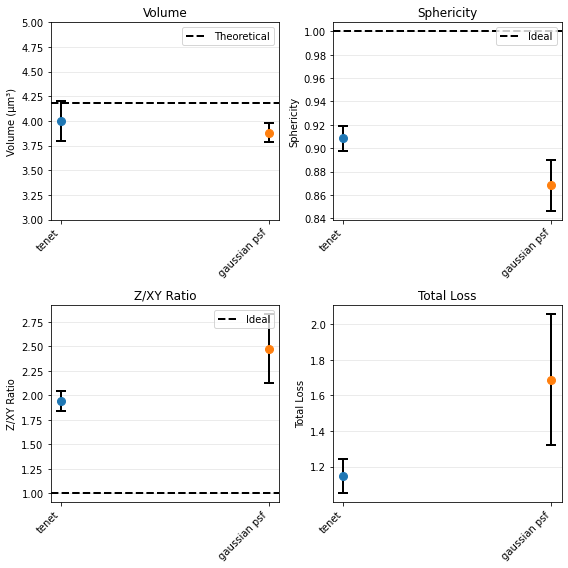

In [18]:
# Prepare data for error bar plots at threshold 0.5
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Separate methods into two groups
ablation_methods = [
    "tenet",
    "without ewc loss", 
    "without psf loss", 
    "without vq loss"
]

add_loss_methods = [
    "tenet",
    "x2 ewc loss", 
    "x2 psf loss", 
    "x2 vq loss", 
    "x1 mrf",
    "gaussian psf"
]

add_loss_methods = [
    "tenet",
    "gaussian psf"
]

# Indices for each group
ablation_indices = [0, 1, 2, 3]
add_loss_indices = [0, 8]

fixed_threshold = 0.5
fixed_thresh_idx = np.where(thresholds == fixed_threshold)[0][0]

# Function to calculate mean and 95% CI
def calc_ci95(data):
    mu = data.mean()
    s2 = data.var(ddof=1)
    ci95 = 2.045 * ((s2 / len(data)) ** 0.5)
    return mu, ci95

# Error bar plots for Ablation Study
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
#fig.suptitle('Ablation Study (Removing Loss Components)', fontsize=16, fontweight='bold')

# Volume
mus = [volumes[i, fixed_thresh_idx, :].mean() for i in ablation_indices]
cis = [calc_ci95(volumes[i, fixed_thresh_idx, :])[1] for i in ablation_indices]
x = np.arange(len(ablation_indices))
for i in range(len(ablation_indices)):
    axes[0, 0].errorbar(x[i], mus[i], cis[i], fmt='o', color=colors[i], capsize=5, capthick=2, markersize=8, ecolor='black', elinewidth=2)
axes[0, 0].set_xticks(range(len(ablation_indices)))
axes[0, 0].set_xticklabels(ablation_methods, rotation=45, ha='right')
axes[0, 0].set_ylabel('Volume (μm³)')
axes[0, 0].set_title(f'Volume')
axes[0, 0].axhline(y=4.187, color='black', linestyle='--', linewidth=2, label='Theoretical')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([2.5, 5])

# Sphericity
mus = [sphericities[i, fixed_thresh_idx, :].mean() for i in ablation_indices]
cis = [calc_ci95(sphericities[i, fixed_thresh_idx, :])[1] for i in ablation_indices]
for i in range(len(ablation_indices)):
    axes[0, 1].errorbar(x[i], mus[i], cis[i], fmt='o', color=colors[i], capsize=5, capthick=2, markersize=8, ecolor='black', elinewidth=2)
axes[0, 1].set_xticks(range(len(ablation_indices)))
axes[0, 1].set_xticklabels(ablation_methods, rotation=45, ha='right')
axes[0, 1].set_ylabel('Sphericity')
axes[0, 1].set_title(f'Sphericity')
axes[0, 1].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Z/XY Ratio
mus = [z_xy_ratios[i, fixed_thresh_idx, :].mean() for i in ablation_indices]
cis = [calc_ci95(z_xy_ratios[i, fixed_thresh_idx, :])[1] for i in ablation_indices]
for i in range(len(ablation_indices)):
    axes[1, 0].errorbar(x[i], mus[i], cis[i], fmt='o', color=colors[i], capsize=5, capthick=2, markersize=8, ecolor='black', elinewidth=2)
axes[1, 0].set_xticks(range(len(ablation_indices)))
axes[1, 0].set_xticklabels(ablation_methods, rotation=45, ha='right')
axes[1, 0].set_ylabel('Z/XY Ratio')
axes[1, 0].set_title(f'Z/XY Ratio')
axes[1, 0].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Total Loss
loss_data = []
for i in ablation_indices:
    losses = np.abs((volumes[i, fixed_thresh_idx, :] - 4.187) / 4.187) + \
             np.abs(sphericities[i, fixed_thresh_idx, :] - 1) + \
             np.abs(z_xy_ratios[i, fixed_thresh_idx, :] - 1)
    loss_data.append(losses)
mus = [loss_data[i].mean() for i in range(len(ablation_indices))]
cis = [calc_ci95(loss_data[i])[1] for i in range(len(ablation_indices))]
for i in range(len(ablation_indices)):
    axes[1, 1].errorbar(x[i], mus[i], cis[i], fmt='o', color=colors[i], capsize=5, capthick=2, markersize=8, ecolor='black', elinewidth=2)
axes[1, 1].set_xticks(range(len(ablation_indices)))
axes[1, 1].set_xticklabels(ablation_methods, rotation=45, ha='right')
axes[1, 1].set_ylabel('Total Loss')
axes[1, 1].set_title(f'Total Loss')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ablation_study_errorbar_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Error bar plots for Add Loss Experiment
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
#fig.suptitle('Add Loss Experiment (Increasing Loss Weights)', fontsize=16, fontweight='bold')

# Volume
mus = [volumes[i, fixed_thresh_idx, :].mean() for i in add_loss_indices]
cis = [calc_ci95(volumes[i, fixed_thresh_idx, :])[1] for i in add_loss_indices]
x = np.arange(len(add_loss_indices))
for i in range(len(add_loss_indices)):
    axes[0, 0].errorbar(x[i], mus[i], cis[i], fmt='o', color=colors[i], capsize=5, capthick=2, markersize=8, ecolor='black', elinewidth=2)
axes[0, 0].set_xticks(range(len(add_loss_indices)))
axes[0, 0].set_xticklabels(add_loss_methods, rotation=45, ha='right')
axes[0, 0].set_ylabel('Volume (μm³)')
axes[0, 0].set_title(f'Volume')
axes[0, 0].axhline(y=4.187, color='black', linestyle='--', linewidth=2, label='Theoretical')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([3, 5])


# Sphericity
mus = [sphericities[i, fixed_thresh_idx, :].mean() for i in add_loss_indices]
cis = [calc_ci95(sphericities[i, fixed_thresh_idx, :])[1] for i in add_loss_indices]
for i in range(len(add_loss_indices)):
    axes[0, 1].errorbar(x[i], mus[i], cis[i], fmt='o', color=colors[i], capsize=5, capthick=2, markersize=8, ecolor='black', elinewidth=2)
axes[0, 1].set_xticks(range(len(add_loss_indices)))
axes[0, 1].set_xticklabels(add_loss_methods, rotation=45, ha='right')
axes[0, 1].set_ylabel('Sphericity')
axes[0, 1].set_title(f'Sphericity')
axes[0, 1].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Z/XY Ratio
mus = [z_xy_ratios[i, fixed_thresh_idx, :].mean() for i in add_loss_indices]
cis = [calc_ci95(z_xy_ratios[i, fixed_thresh_idx, :])[1] for i in add_loss_indices]
for i in range(len(add_loss_indices)):
    axes[1, 0].errorbar(x[i], mus[i], cis[i], fmt='o', color=colors[i], capsize=5, capthick=2, markersize=8, ecolor='black', elinewidth=2)
axes[1, 0].set_xticks(range(len(add_loss_indices)))
axes[1, 0].set_xticklabels(add_loss_methods, rotation=45, ha='right')
axes[1, 0].set_ylabel('Z/XY Ratio')
axes[1, 0].set_title(f'Z/XY Ratio')
axes[1, 0].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Total Loss
loss_data = []
for i in add_loss_indices:
    losses = np.abs((volumes[i, fixed_thresh_idx, :] - 4.187) / 4.187) + \
             np.abs(sphericities[i, fixed_thresh_idx, :] - 1) + \
             np.abs(z_xy_ratios[i, fixed_thresh_idx, :] - 1)
    loss_data.append(losses)
mus = [loss_data[i].mean() for i in range(len(add_loss_indices))]
cis = [calc_ci95(loss_data[i])[1] for i in range(len(add_loss_indices))]
for i in range(len(add_loss_indices)):
    axes[1, 1].errorbar(x[i], mus[i], cis[i], fmt='o', color=colors[i], capsize=5, capthick=2, markersize=8, ecolor='black', elinewidth=2)
axes[1, 1].set_xticks(range(len(add_loss_indices)))
axes[1, 1].set_xticklabels(add_loss_methods, rotation=45, ha='right')
axes[1, 1].set_ylabel('Total Loss')
axes[1, 1].set_title(f'Total Loss')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('add_loss_experiment_errorbar_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# --- Ablation summary (mean + 95% CI half-width) ---
ablation_summary = {
    'Method': ablation_methods,
    'Volume_Mean':     [volume_mean[i, fixed_thresh_idx]     for i in ablation_indices],
    'Volume_CI95':     [volume_std[i, fixed_thresh_idx]      * 2.045 / np.sqrt(30) for i in ablation_indices],
    'Sphericity_Mean': [sphericity_mean[i, fixed_thresh_idx] for i in ablation_indices],
    'Sphericity_CI95': [sphericity_std[i, fixed_thresh_idx]  * 2.045 / np.sqrt(30) for i in ablation_indices],
    'Z/XY_Ratio_Mean': [z_xy_ratio_mean[i, fixed_thresh_idx] for i in ablation_indices],
    'Z/XY_Ratio_CI95': [z_xy_ratio_std[i, fixed_thresh_idx]  * 2.045 / np.sqrt(30) for i in ablation_indices],
}

# Total loss mean + 95% CI for ablation
total_loss_ablation_mean = []
total_loss_ablation_ci95 = []
for i in ablation_indices:
    losses = np.abs((volumes[i, fixed_thresh_idx, :] - 4.187) / 4.187) + \
             np.abs(sphericities[i, fixed_thresh_idx, :] - 1) + \
             np.abs(z_xy_ratios[i, fixed_thresh_idx, :] - 1)
    total_loss_ablation_mean.append(np.nanmean(losses))
    total_loss_ablation_ci95.append(2.045 * np.nanstd(losses, ddof=1) / np.sqrt(30))

ablation_summary['Total_Loss_Mean'] = total_loss_ablation_mean
ablation_summary['Total_Loss_CI95'] = total_loss_ablation_ci95

df_ablation_summary = pd.DataFrame(ablation_summary)
df_ablation_summary.to_csv('ablation_study_summary.csv', index=False)
print("Ablation study summary saved to ablation_study_summary.csv")

# --- Add-loss summary (mean + 95% CI half-width) ---
add_loss_summary = {
    'Method': add_loss_methods,
    'Volume_Mean':     [volume_mean[i, fixed_thresh_idx]     for i in add_loss_indices],
    'Volume_CI95':     [volume_std[i, fixed_thresh_idx]      * 2.045 / np.sqrt(30) for i in add_loss_indices],
    'Sphericity_Mean': [sphericity_mean[i, fixed_thresh_idx] for i in add_loss_indices],
    'Sphericity_CI95': [sphericity_std[i, fixed_thresh_idx]  * 2.045 / np.sqrt(30) for i in add_loss_indices],
    'Z/XY_Ratio_Mean': [z_xy_ratio_mean[i, fixed_thresh_idx] for i in add_loss_indices],
    'Z/XY_Ratio_CI95': [z_xy_ratio_std[i, fixed_thresh_idx]  * 2.045 / np.sqrt(30) for i in add_loss_indices],
}

# Total loss mean + 95% CI for add-loss
total_loss_add_loss_mean = []
total_loss_add_loss_ci95 = []
for i in add_loss_indices:
    losses = np.abs((volumes[i, fixed_thresh_idx, :] - 4.187) / 4.187) + \
             np.abs(sphericities[i, fixed_thresh_idx, :] - 1) + \
             np.abs(z_xy_ratios[i, fixed_thresh_idx, :] - 1)
    total_loss_add_loss_mean.append(np.nanmean(losses))
    total_loss_add_loss_ci95.append(2.045 * np.nanstd(losses, ddof=1) / np.sqrt(30))

add_loss_summary['Total_Loss_Mean'] = total_loss_add_loss_mean
add_loss_summary['Total_Loss_CI95'] = total_loss_add_loss_ci95

df_add_loss_summary = pd.DataFrame(add_loss_summary)
df_add_loss_summary.to_csv('add_loss_experiment_summary.csv', index=False)
print("Add loss experiment summary saved to add_loss_experiment_summary.csv")

# Print summaries
print("\n=== Ablation Study Summary ===")
print(df_ablation_summary.to_string(index=False))

print("\n=== Add Loss Experiment Summary ===")
print(df_add_loss_summary.to_string(index=False))


Ablation study summary saved to ablation_study_summary.csv
Add loss experiment summary saved to add_loss_experiment_summary.csv

=== Ablation Study Summary ===
          Method  Volume_Mean  Volume_CI95  Sphericity_Mean  Sphericity_CI95  Z/XY_Ratio_Mean  Z/XY_Ratio_CI95  Total_Loss_Mean  Total_Loss_CI95
           tenet     4.003383     0.198435         0.908319         0.010302         1.942392         0.096558         1.146329         0.095825
without ewc loss     3.084538     0.183418         0.871722         0.014453         2.332664         0.372144         1.724248         0.403068
without psf loss     4.155017     0.133105         0.885171         0.016081         2.649057         0.479408         1.832073         0.499925
 without vq loss     4.236279     0.232116         0.811551         0.042511         3.216107         0.459679         2.535766         0.507283

=== Add Loss Experiment Summary ===
      Method  Volume_Mean  Volume_CI95  Sphericity_Mean  Sphericity_CI95  Z/XY

In [20]:
# Use fixed threshold of 0.5 for all methods
fixed_threshold = 0.5
fixed_thresh_idx = np.where(thresholds == fixed_threshold)[0][0]

# Print metrics at fixed threshold 0.5
print("\n=== Performance at fixed threshold 0.5 ===")
for method_idx, method_name in enumerate(methods):
    print(f"\n{method_name.upper()}:")
    print(f"  Volume: {volume_mean[method_idx, fixed_thresh_idx]:.3f} ± {volume_std[method_idx, fixed_thresh_idx]:.3f} (loss: {volume_loss_mean[method_idx, fixed_thresh_idx]:.3f})")
    print(f"  Sphericity: {sphericity_mean[method_idx, fixed_thresh_idx]:.3f} ± {sphericity_std[method_idx, fixed_thresh_idx]:.3f} (loss: {sphericity_loss_mean[method_idx, fixed_thresh_idx]:.3f})")
    print(f"  Z/XY Ratio: {z_xy_ratio_mean[method_idx, fixed_thresh_idx]:.3f} ± {z_xy_ratio_std[method_idx, fixed_thresh_idx]:.3f} (loss: {z_xy_loss_mean[method_idx, fixed_thresh_idx]:.3f})")
    print(f"  Total Loss: {total_loss_mean[method_idx, fixed_thresh_idx]:.3f}")


=== Performance at fixed threshold 0.5 ===

TENET:
  Volume: 4.003 ± 0.531 (loss: 0.044)
  Sphericity: 0.908 ± 0.028 (loss: 0.092)
  Z/XY Ratio: 1.942 ± 0.259 (loss: 0.942)
  Total Loss: 1.078

WITHOUT EWC LOSS:
  Volume: 3.085 ± 0.491 (loss: 0.263)
  Sphericity: 0.872 ± 0.039 (loss: 0.128)
  Z/XY Ratio: 2.333 ± 0.997 (loss: 1.333)
  Total Loss: 1.724

WITHOUT PSF LOSS:
  Volume: 4.155 ± 0.357 (loss: 0.008)
  Sphericity: 0.885 ± 0.043 (loss: 0.115)
  Z/XY Ratio: 2.649 ± 1.284 (loss: 1.649)
  Total Loss: 1.772

WITHOUT VQ LOSS:
  Volume: 4.236 ± 0.622 (loss: 0.012)
  Sphericity: 0.812 ± 0.114 (loss: 0.188)
  Z/XY Ratio: 3.216 ± 1.231 (loss: 2.216)
  Total Loss: 2.416

X2 EWC LOSS:
  Volume: 4.010 ± 0.507 (loss: 0.042)
  Sphericity: 0.873 ± 0.073 (loss: 0.127)
  Z/XY Ratio: 2.546 ± 0.964 (loss: 1.546)
  Total Loss: 1.715

X2 PSF LOSS:
  Volume: 3.996 ± 0.435 (loss: 0.046)
  Sphericity: 0.862 ± 0.047 (loss: 0.138)
  Z/XY Ratio: 2.736 ± 1.041 (loss: 1.736)
  Total Loss: 1.920

X2 VQ LOSS:

IndexError: list index out of range

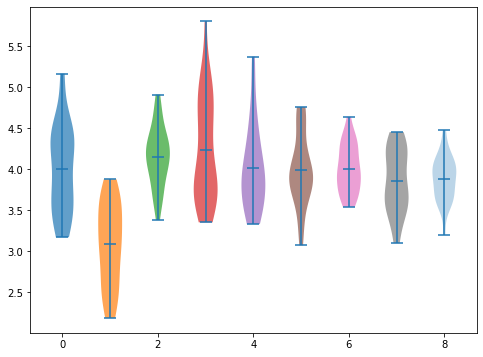

In [21]:
colors = colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
# Prepare data for violin plot at threshold 0.5
fixed_threshold = 0.5
fixed_thresh_idx = np.where(thresholds == fixed_threshold)[0][0]

# Extract volumes at fixed threshold for all methods and samples
violin_data = []
for method_idx in range(num_methods):
    violin_data.append(volumes[method_idx, fixed_thresh_idx, :])

# Create violin plot
fig, ax = plt.subplots(figsize=(8, 6))
parts = ax.violinplot(violin_data, positions=range(num_methods), showmeans=True, )

# Customize colors
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

ax.set_xticks(range(num_methods))
ax.set_xticklabels(methods)
ax.set_ylabel('Volume (μm³)')
ax.set_title(f'Volume')
ax.axhline(y=4.187, color='black', linestyle='--', linewidth=2, label='Theoretical')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

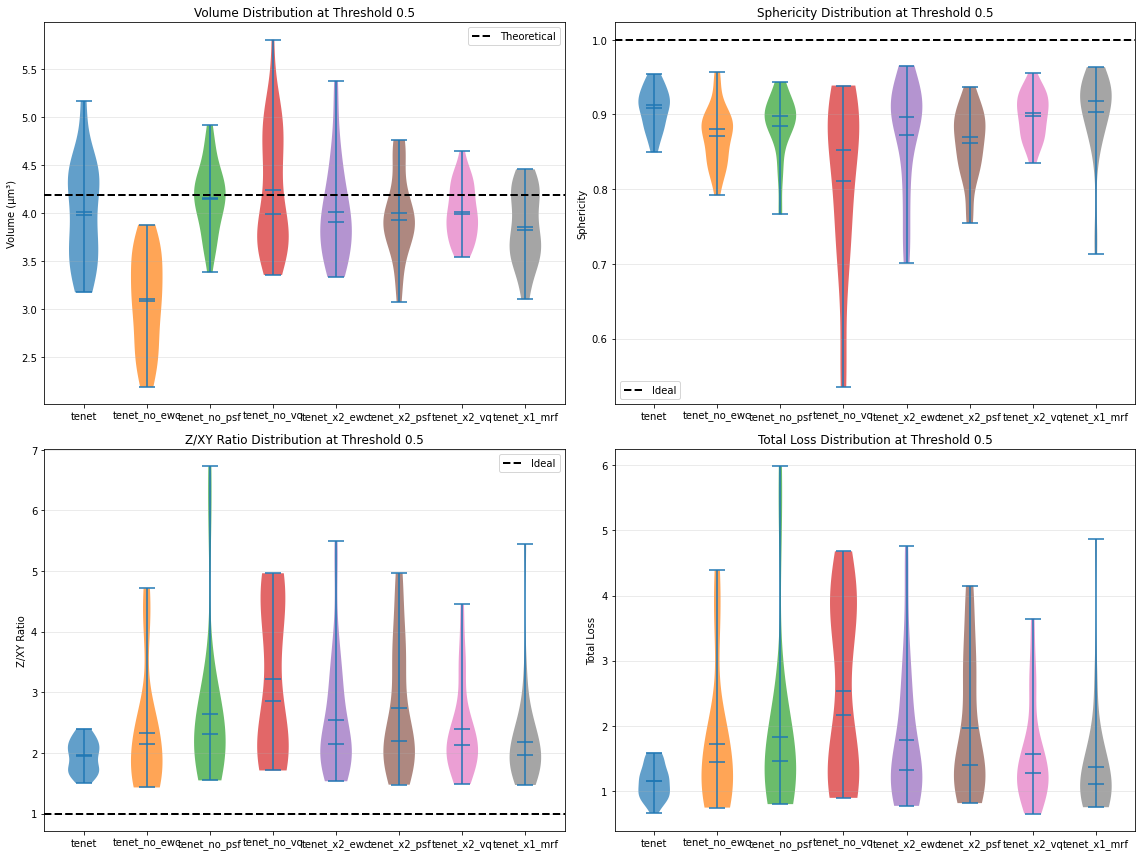

In [ ]:
# Prepare data for violin plots at threshold 0.5
fixed_threshold = 0.5
fixed_thresh_idx = np.where(thresholds == fixed_threshold)[0][0]

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Volume violin plot
violin_data_volume = []
for method_idx in range(num_methods):
    violin_data_volume.append(volumes[method_idx, fixed_thresh_idx, :])

parts = axes[0, 0].violinplot(violin_data_volume, positions=range(num_methods), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[0, 0].set_xticks(range(num_methods))
axes[0, 0].set_xticklabels(methods)
axes[0, 0].set_ylabel('Volume (μm³)')
axes[0, 0].set_title(f'Volume')
axes[0, 0].axhline(y=4.187, color='black', linestyle='--', linewidth=2, label='Theoretical')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Sphericity violin plot
violin_data_sphericity = []
for method_idx in range(num_methods):
    violin_data_sphericity.append(sphericities[method_idx, fixed_thresh_idx, :])

parts = axes[0, 1].violinplot(violin_data_sphericity, positions=range(num_methods), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[0, 1].set_xticks(range(num_methods))
axes[0, 1].set_xticklabels(methods)
axes[0, 1].set_ylabel('Sphericity')
axes[0, 1].set_title(f'Sphericity')
axes[0, 1].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Z/XY Ratio violin plot
violin_data_zxy = []
for method_idx in range(num_methods):
    violin_data_zxy.append(z_xy_ratios[method_idx, fixed_thresh_idx, :])

parts = axes[1, 0].violinplot(violin_data_zxy, positions=range(num_methods), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[1, 0].set_xticks(range(num_methods))
axes[1, 0].set_xticklabels(methods)
axes[1, 0].set_ylabel('Z/XY Ratio')
axes[1, 0].set_title(f'Z/XY Ratio')
axes[1, 0].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ideal')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Total Loss violin plot
violin_data_total = []
total_loss_samples = volume_loss_mean[:, fixed_thresh_idx:fixed_thresh_idx+1] + sphericity_loss_mean[:, fixed_thresh_idx:fixed_thresh_idx+1] + z_xy_loss_mean[:, fixed_thresh_idx:fixed_thresh_idx+1]
for method_idx in range(num_methods):
    losses = np.abs((volumes[method_idx, fixed_thresh_idx, :] - 4.187) / 4.187) + \
             np.abs(sphericities[method_idx, fixed_thresh_idx, :] - 1) + \
             np.abs(z_xy_ratios[method_idx, fixed_thresh_idx, :] - 1)
    violin_data_total.append(losses)

parts = axes[1, 1].violinplot(violin_data_total, positions=range(num_methods), showmeans=True, )
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
axes[1, 1].set_xticks(range(num_methods))
axes[1, 1].set_xticklabels(methods)
axes[1, 1].set_ylabel('Total Loss')
axes[1, 1].set_title(f'Total Loss')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

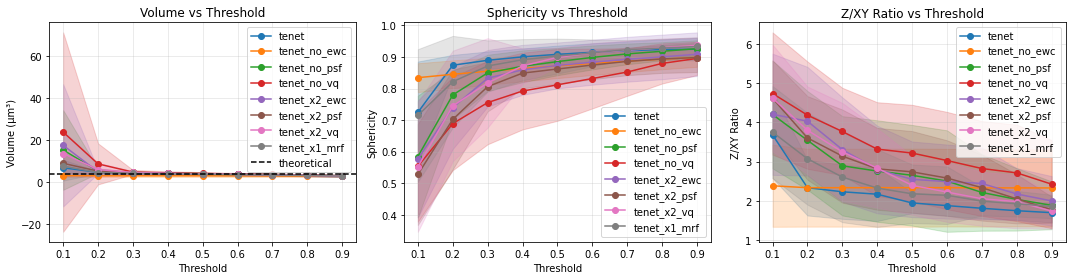

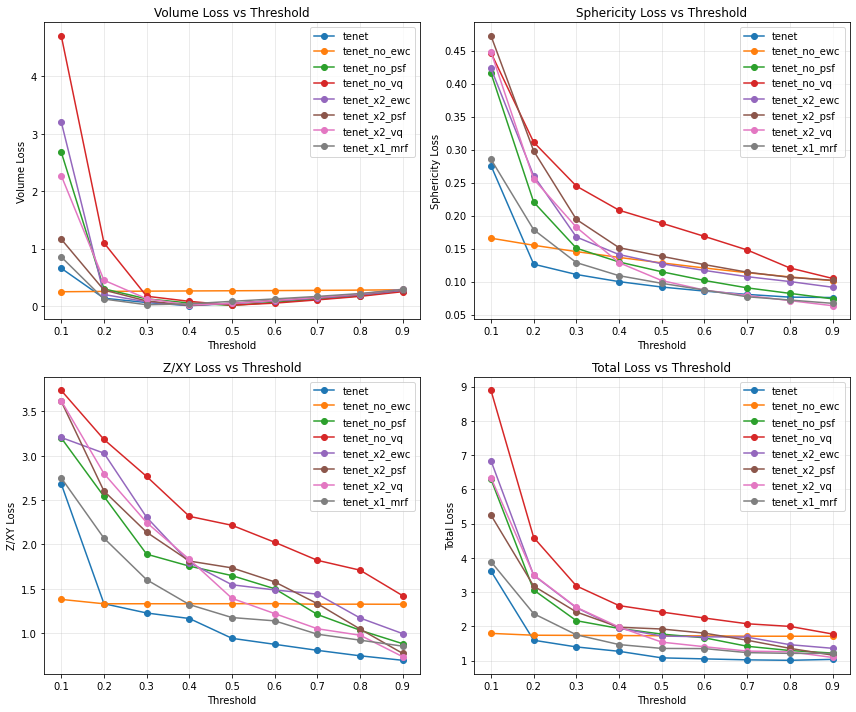

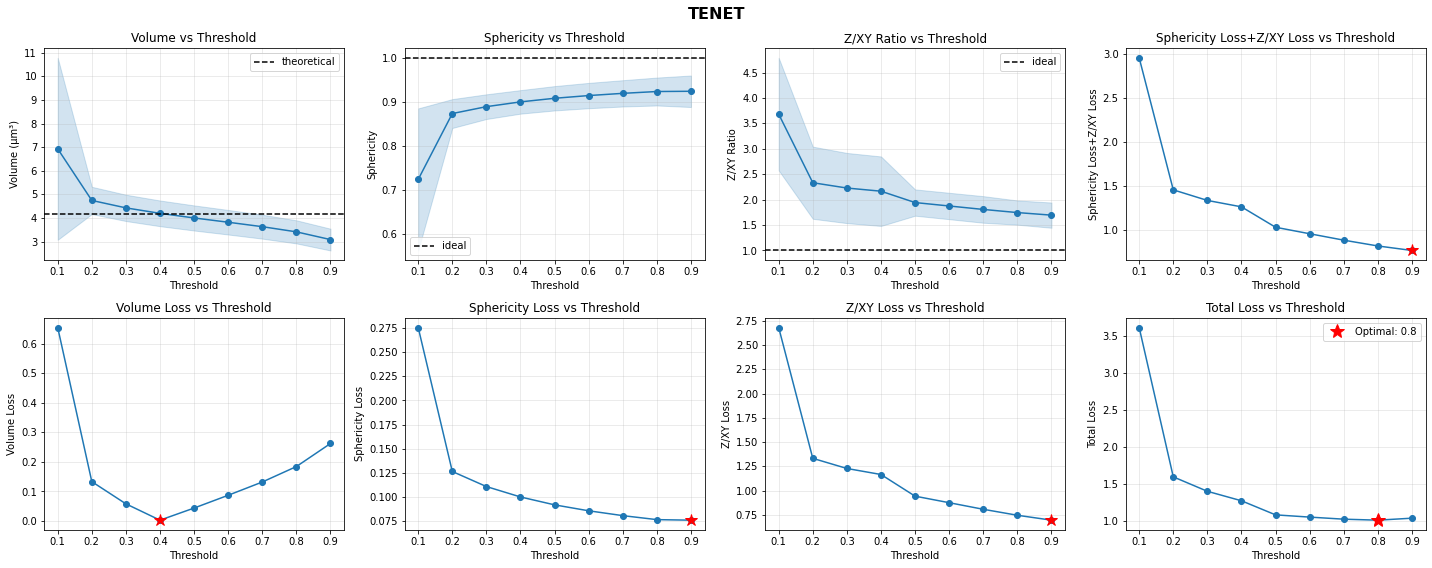

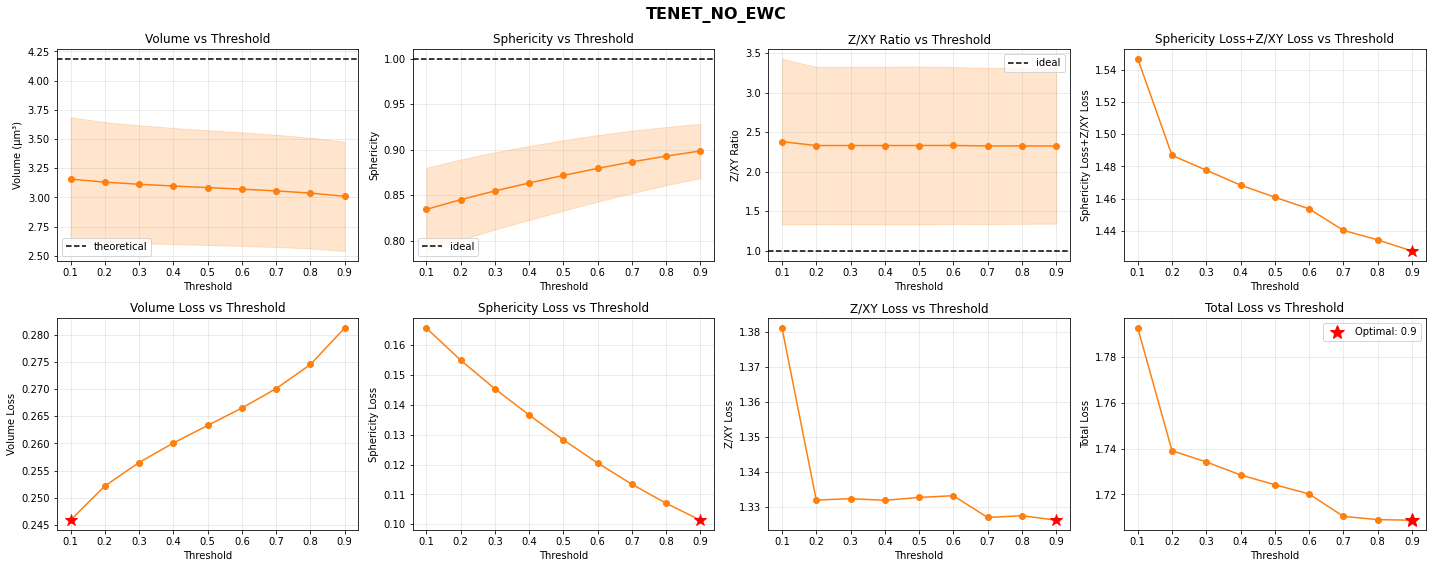

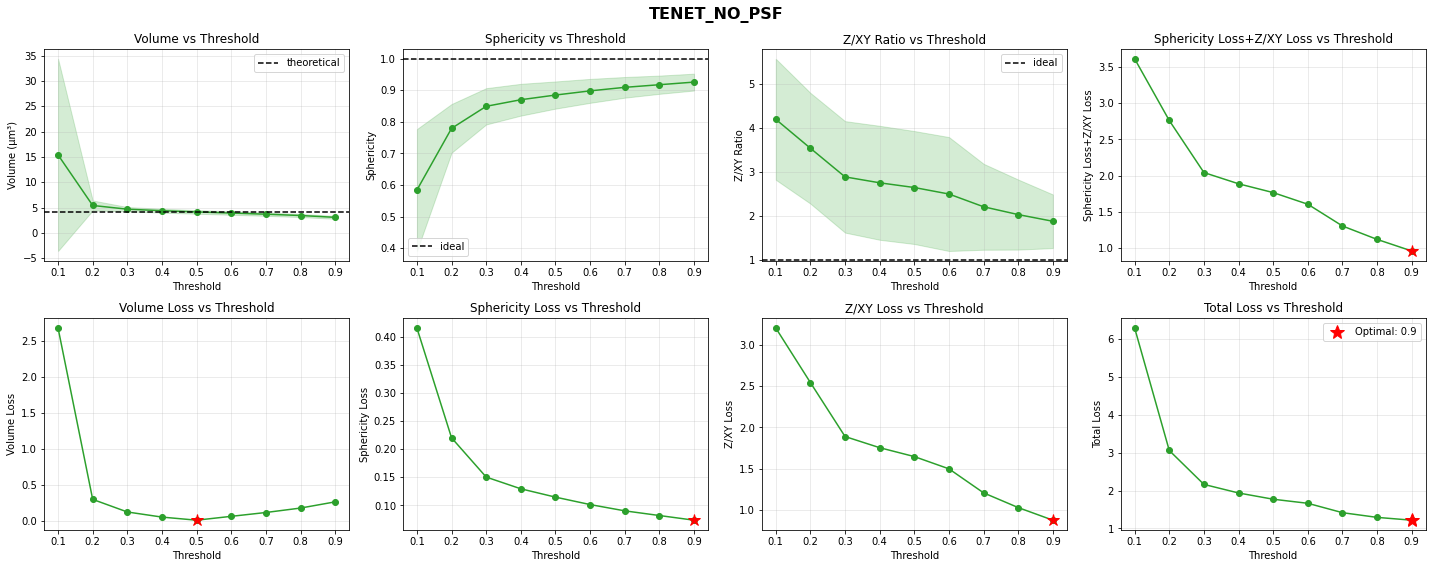

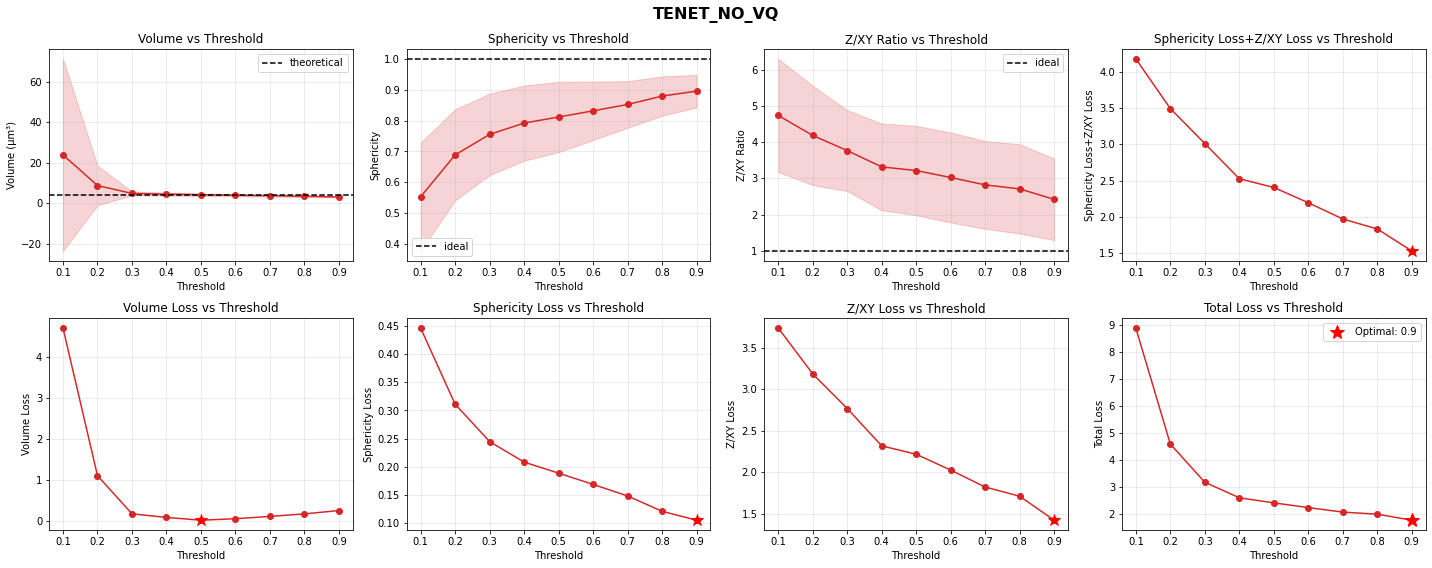

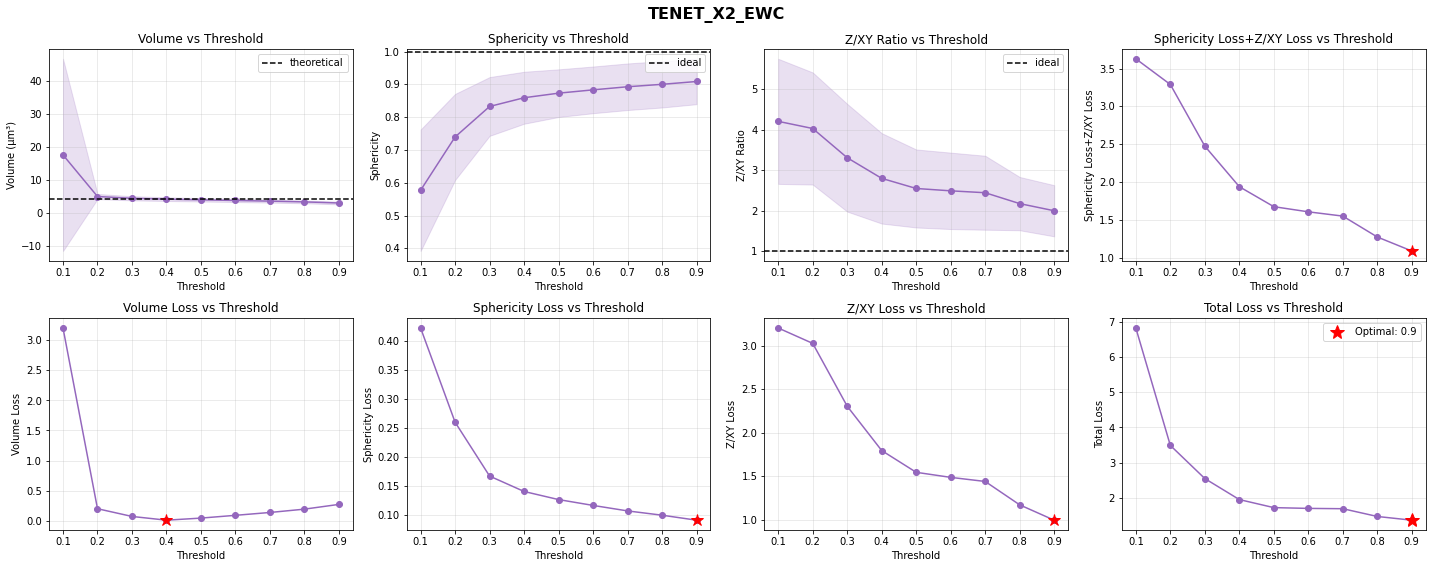

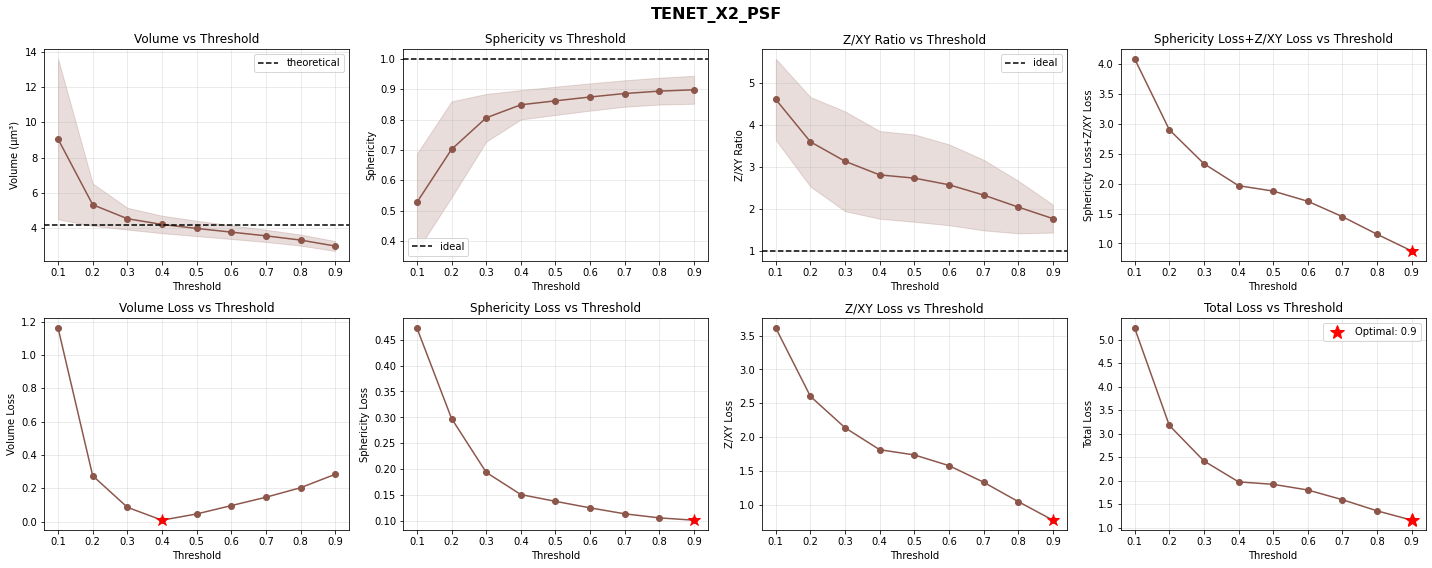

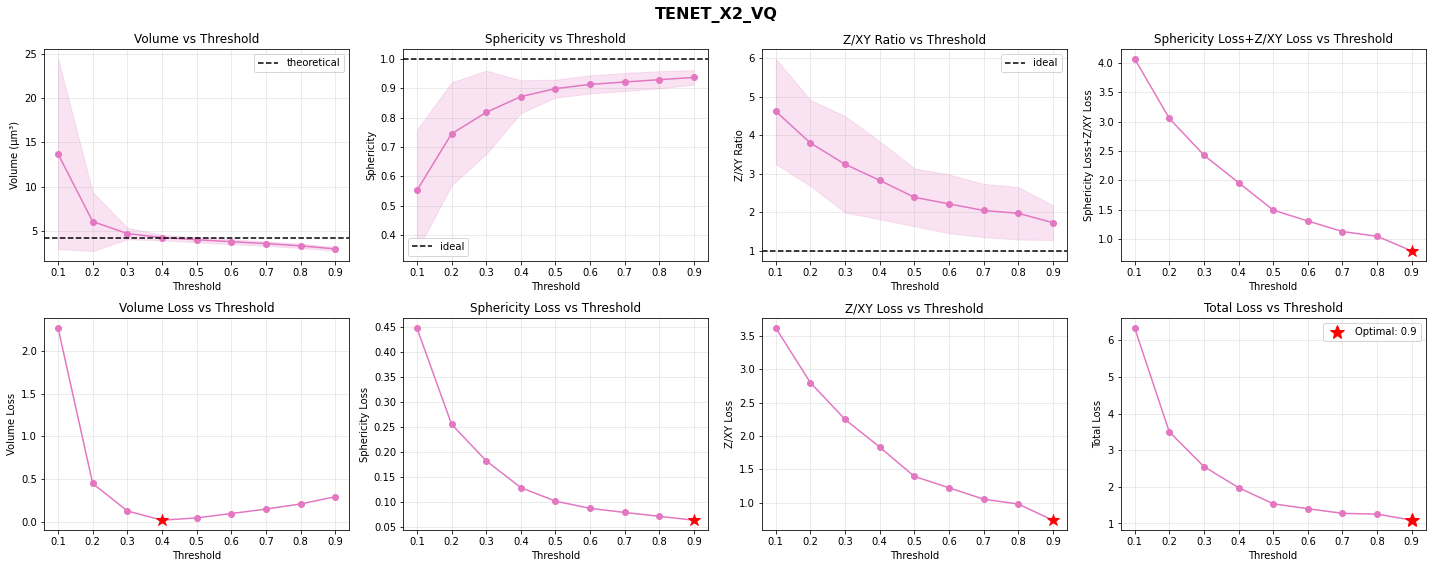

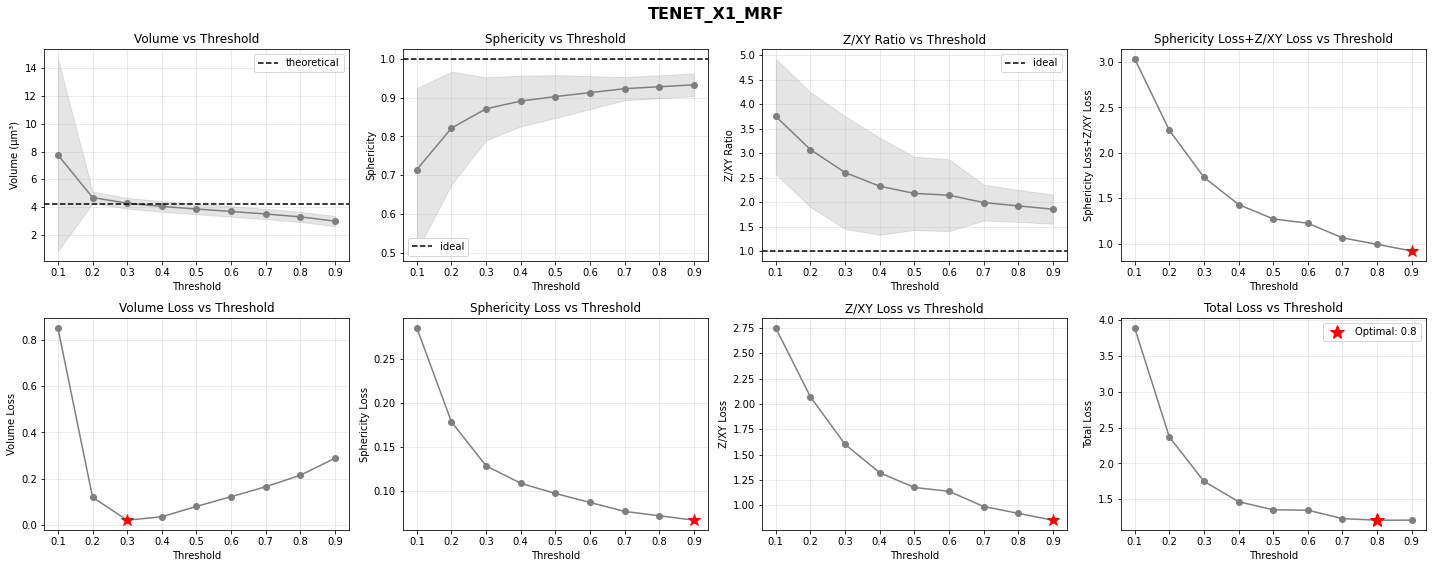


=== Optimal thresholds (by minimum total loss) ===

TENET:
  Optimal threshold: 0.8
  Volume: 3.415 (loss: 0.184)
  Sphericity: 0.924 (loss: 0.076)
  Z/XY Ratio: 1.745 (loss: 0.745)
  Total Loss: 1.006

TENET_NO_EWC:
  Optimal threshold: 0.9
  Volume: 3.010 (loss: 0.281)
  Sphericity: 0.899 (loss: 0.101)
  Z/XY Ratio: 2.326 (loss: 1.326)
  Total Loss: 1.709

TENET_NO_PSF:
  Optimal threshold: 0.9
  Volume: 3.089 (loss: 0.262)
  Sphericity: 0.926 (loss: 0.074)
  Z/XY Ratio: 1.882 (loss: 0.882)
  Total Loss: 1.218

TENET_NO_VQ:
  Optimal threshold: 0.9
  Volume: 3.151 (loss: 0.248)
  Sphericity: 0.895 (loss: 0.105)
  Z/XY Ratio: 2.422 (loss: 1.422)
  Total Loss: 1.775

TENET_X2_EWC:
  Optimal threshold: 0.9
  Volume: 3.055 (loss: 0.270)
  Sphericity: 0.909 (loss: 0.091)
  Z/XY Ratio: 1.995 (loss: 0.995)
  Total Loss: 1.357

TENET_X2_PSF:
  Optimal threshold: 0.9
  Volume: 2.999 (loss: 0.284)
  Sphericity: 0.898 (loss: 0.102)
  Z/XY Ratio: 1.772 (loss: 0.772)
  Total Loss: 1.157

TENET_X

In [ ]:
# Plot results - Combined view (all methods on each metric)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Plot Volume
for method_idx, method_name in enumerate(methods):
    axes[0].plot(thresholds, volume_mean[method_idx], 'o-', 
                 color=colors[method_idx], label=method_name)
    axes[0].fill_between(thresholds, 
                         volume_mean[method_idx] - volume_std[method_idx],
                         volume_mean[method_idx] + volume_std[method_idx],
                         color=colors[method_idx], alpha=0.2)
axes[0].axhline(y=4.187, color='black', linestyle='--', label='theoretical')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Volume (μm³)')
axes[0].set_title('Volume vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Sphericity
for method_idx, method_name in enumerate(methods):
    axes[1].plot(thresholds, sphericity_mean[method_idx], 'o-',
                 color=colors[method_idx], label=method_name)
    axes[1].fill_between(thresholds,
                         sphericity_mean[method_idx] - sphericity_std[method_idx],
                         sphericity_mean[method_idx] + sphericity_std[method_idx],
                         color=colors[method_idx], alpha=0.2)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Sphericity')
axes[1].set_title('Sphericity vs Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot Z/XY Ratio
for method_idx, method_name in enumerate(methods):
    axes[2].plot(thresholds, z_xy_ratio_mean[method_idx], 'o-',
                 color=colors[method_idx], label=method_name)
    axes[2].fill_between(thresholds,
                         z_xy_ratio_mean[method_idx] - z_xy_ratio_std[method_idx],
                         z_xy_ratio_mean[method_idx] + z_xy_ratio_std[method_idx],
                         color=colors[method_idx], alpha=0.2)
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Z/XY Ratio')
axes[2].set_title('Z/XY Ratio vs Threshold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot losses - Combined view
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Volume Loss
for method_idx, method_name in enumerate(methods):
    axes[0, 0].plot(thresholds, volume_loss_mean[method_idx], 'o-',
                    color=colors[method_idx], label=method_name)
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Volume Loss')
axes[0, 0].set_title('Volume Loss vs Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot Sphericity Loss
for method_idx, method_name in enumerate(methods):
    axes[0, 1].plot(thresholds, sphericity_loss_mean[method_idx], 'o-',
                    color=colors[method_idx], label=method_name)
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Sphericity Loss')
axes[0, 1].set_title('Sphericity Loss vs Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Z/XY Loss
for method_idx, method_name in enumerate(methods):
    axes[1, 0].plot(thresholds, z_xy_loss_mean[method_idx], 'o-',
                    color=colors[method_idx], label=method_name)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Z/XY Loss')
axes[1, 0].set_title('Z/XY Loss vs Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot Total Loss
for method_idx, method_name in enumerate(methods):
    axes[1, 1].plot(thresholds, total_loss_mean[method_idx], 'o-',
                    color=colors[method_idx], label=method_name)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Total Loss')
axes[1, 1].set_title('Total Loss vs Threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot results - Individual method view (each method has 3 metrics + 4 losses)
for method_idx, method_name in enumerate(methods):

    best_vol_loss_idx = np.argmin(volume_loss_mean[method_idx])
    best_vol_loss_thresh = thresholds[best_vol_loss_idx]
    
    best_sph_loss_idx = np.argmin(sphericity_loss_mean[method_idx])
    best_sph_loss_thresh = thresholds[best_sph_loss_idx]
    
    best_zxy_loss_idx = np.argmin(z_xy_loss_mean[method_idx])
    best_zxy_loss_thresh = thresholds[best_zxy_loss_idx]
    
    best_sphe_zxy_loss_idx = np.argmin(z_xy_loss_mean[method_idx]+ sphericity_loss_mean[method_idx])
    best_sphe_zxy_loss_thresh = thresholds[best_sphe_zxy_loss_idx]

    best_total_loss_idx = np.argmin(total_loss_mean[method_idx])
    best_total_loss_thresh = thresholds[best_total_loss_idx]
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    fig.suptitle(method_name.upper(), fontsize=16, fontweight='bold')
    
    # Row 1: Original metrics
    # Plot Volume
    axes[0, 0].plot(thresholds, volume_mean[method_idx], 'o-', color=colors[method_idx])
    axes[0, 0].fill_between(thresholds,
                         volume_mean[method_idx] - volume_std[method_idx],
                         volume_mean[method_idx] + volume_std[method_idx],
                         color=colors[method_idx], alpha=0.2)
    axes[0, 0].axhline(y=4.187, color='black', linestyle='--', label='theoretical')
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('Volume (μm³)')
    axes[0, 0].set_title('Volume vs Threshold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot Sphericity
    axes[0, 1].plot(thresholds, sphericity_mean[method_idx], 'o-', color=colors[method_idx])
    axes[0, 1].fill_between(thresholds,
                         sphericity_mean[method_idx] - sphericity_std[method_idx],
                         sphericity_mean[method_idx] + sphericity_std[method_idx],
                         color=colors[method_idx], alpha=0.2)
    axes[0, 1].axhline(y=1.0, color='black', linestyle='--', label='ideal')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Sphericity')
    axes[0, 1].set_title('Sphericity vs Threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot Z/XY Ratio
    axes[0, 2].plot(thresholds, z_xy_ratio_mean[method_idx], 'o-', color=colors[method_idx])
    axes[0, 2].fill_between(thresholds,
                         z_xy_ratio_mean[method_idx] - z_xy_ratio_std[method_idx],
                         z_xy_ratio_mean[method_idx] + z_xy_ratio_std[method_idx],
                         color=colors[method_idx], alpha=0.2)
    axes[0, 2].axhline(y=1.0, color='black', linestyle='--', label='ideal')
    axes[0, 2].set_xlabel('Threshold')
    axes[0, 2].set_ylabel('Z/XY Ratio')
    axes[0, 2].set_title('Z/XY Ratio vs Threshold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    
    # Row 2: Losses
    # Plot Volume Loss
    axes[1, 0].plot(thresholds, volume_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('Volume Loss')
    axes[1, 0].set_title('Volume Loss vs Threshold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot Sphericity Loss
    axes[1, 1].plot(thresholds, sphericity_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Sphericity Loss')
    axes[1, 1].set_title('Sphericity Loss vs Threshold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot Z/XY Loss
    axes[1, 2].plot(thresholds, z_xy_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[1, 2].set_xlabel('Threshold')
    axes[1, 2].set_ylabel('Z/XY Loss')
    axes[1, 2].set_title('Z/XY Loss vs Threshold')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Plot Total Loss
    axes[1, 3].plot(thresholds, total_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[1, 3].set_xlabel('Threshold')
    axes[1, 3].set_ylabel('Total Loss')
    axes[1, 3].set_title('Total Loss vs Threshold')
    axes[1, 3].grid(True, alpha=0.3)

    optimal_thresh = optimal_thresholds[method_idx]
    optimal_loss = total_loss_mean[method_idx, optimal_indices[method_idx]]
    axes[1, 3].plot(optimal_thresh, optimal_loss, 'r*', markersize=15, label=f'Optimal: {optimal_thresh:.1f}')
    axes[1, 3].legend()

        # Plot Total Loss
    axes[0, 3].plot(thresholds, sphericity_loss_mean[method_idx]+ z_xy_loss_mean[method_idx], 'o-', color=colors[method_idx])
    axes[0, 3].set_xlabel('Threshold')
    axes[0, 3].set_ylabel('Sphericity Loss+Z/XY Loss')
    axes[0, 3].set_title('Sphericity Loss+Z/XY Loss vs Threshold')
    axes[0, 3].grid(True, alpha=0.3)

    axes[0, 3].plot(best_sphe_zxy_loss_thresh, sphe_zxy_loss_mean[method_idx, best_sphe_zxy_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_vol_loss_thresh:.1f}')

    axes[1, 0].plot(best_vol_loss_thresh, volume_loss_mean[method_idx, best_vol_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_vol_loss_thresh:.1f}')
    
    axes[1, 1].plot(best_sph_loss_thresh, sphericity_loss_mean[method_idx, best_sph_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_sph_loss_thresh:.1f}')
    
    axes[1, 2].plot(best_zxy_loss_thresh, z_xy_loss_mean[method_idx, best_zxy_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_zxy_loss_thresh:.1f}')
    
    axes[1, 3].plot(best_total_loss_thresh, total_loss_mean[method_idx, best_total_loss_idx], 
                    'r*', markersize=12, label=f'Best: {best_total_loss_thresh:.1f}')

    plt.tight_layout()
    plt.show()

# Print optimal thresholds
print("\n=== Optimal thresholds (by minimum total loss) ===")
for method_idx, method_name in enumerate(methods):
    optimal_idx = np.argmin(total_loss_mean[method_idx])
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"\n{method_name.upper()}:")
    print(f"  Optimal threshold: {optimal_threshold:.1f}")
    print(f"  Volume: {volume_mean[method_idx, optimal_idx]:.3f} (loss: {volume_loss_mean[method_idx, optimal_idx]:.3f})")
    print(f"  Sphericity: {sphericity_mean[method_idx, optimal_idx]:.3f} (loss: {sphericity_loss_mean[method_idx, optimal_idx]:.3f})")
    print(f"  Z/XY Ratio: {z_xy_ratio_mean[method_idx, optimal_idx]:.3f} (loss: {z_xy_loss_mean[method_idx, optimal_idx]:.3f})")
    print(f"  Total Loss: {total_loss_mean[method_idx, optimal_idx]:.3f}")

/tmp/ipykernel_1314728/1917402542.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=10)


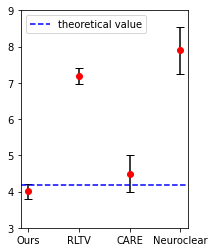

In [ ]:
original_volume   = np.zeros(30)
deconv_volume     = np.zeros(30)
neuroclear_volume = np.zeros(30)
care_volume       = np.zeros(30)
tenet_volume      = np.zeros(30)

for idx in range(30):
    original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
    deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
    tenet      = tifffile.imread(path_of(base, "fig4", "tenet"     , idx))[0]

    # preprocess to 0 to 1
    original    = upsample3d(norm(original  , bit=16), scale=10)
    deconv      = upsample3d(deconv/deconv.max(), scale=10)
    neuroclear  = (norm(neuroclear, bit=16))
    care       /= care.max()
    tenet       = tenet

    original_volume  [idx] = np.sum((original   > 0.5) * 0.05 ** 3)
    deconv_volume    [idx] = np.sum((deconv     > 0.1) * 0.05 ** 3)
    neuroclear_volume[idx] = np.sum((neuroclear > 0.5) * 0.05 ** 3)
    care_volume      [idx] = np.sum((care       > 0.5) * 0.05 ** 3)
    tenet_volume     [idx] = np.sum((tenet      > 0.5) * 0.05 ** 3)

volumes_list = [
    tenet_volume     ,
    deconv_volume    ,
    care_volume      ,
    neuroclear_volume,
]

mus = np.zeros(4)
cis = np.zeros(4)
for i, volumes in enumerate(volumes_list):
    mu = volumes.mean()
    s2 = (volumes.var(ddof=1))
    ci95 = 2.045*((s2/30)**0.5)
    mus[i] = mu
    cis[i] = ci95

x = np.arange(len(mus))
fig, ax = plt.subplots(figsize=(3, 4))
ax.errorbar(x, mus,cis, fmt="ro", capsize=4, ecolor='black')
ax.set_xticks(x)
ax.set_yticks(np.arange(3, 10))
ax.set_xticklabels(["Ours", "RLTV", "CARE", "Neuroclear"])
ax.axhline(y=4.187, color='b', linestyle='--', label='theoretical value')
plt.legend()
plt.tight_layout(pad=10)
plt.show()

/tmp/ipykernel_19203/2685652162.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=10)


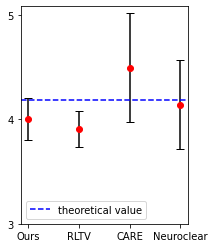

In [ ]:
original_volume   = np.zeros(30)
deconv_volume     = np.zeros(30)
neuroclear_volume = np.zeros(30)
care_volume       = np.zeros(30)
tenet_volume      = np.zeros(30)

for idx in range(30):
    original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
    deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
    tenet      = tifffile.imread(path_of(base, "fig4", "tenet/JNet_603"     , idx))[0]

    # preprocess to 0 to 1
    original    = upsample3d(norm(original  , bit=16), scale=10)
    deconv      = upsample3d(deconv/deconv.max(), scale=10)
    neuroclear  = (norm(neuroclear, bit=16))
    care       /= care.max()
    tenet       = tenet

    original_volume  [idx] = np.sum((original   > 0.5) * 0.05 ** 3)
    deconv_volume    [idx] = np.sum((deconv     > 0.2) * 0.05 ** 3)
    neuroclear_volume[idx] = np.sum((neuroclear > 0.7) * 0.05 ** 3)
    care_volume      [idx] = np.sum((care       > 0.5) * 0.05 ** 3)
    tenet_volume     [idx] = np.sum((tenet      > 0.5) * 0.05 ** 3)

volumes_list = [
    tenet_volume     ,
    deconv_volume    ,
    care_volume      ,
    neuroclear_volume,
]

mus = np.zeros(4)
cis = np.zeros(4)
for i, volumes in enumerate(volumes_list):
    mu = volumes.mean()
    s2 = (volumes.var(ddof=1))
    ci95 = 2.045*((s2/30)**0.5)
    mus[i] = mu
    cis[i] = ci95

x = np.arange(len(mus))
fig, ax = plt.subplots(figsize=(3, 4))
ax.errorbar(x, mus,cis, fmt="ro", capsize=4, ecolor='black')
ax.set_xticks(x)
ax.set_yticks(np.arange(3, 6))
ax.set_xticklabels(["Ours", "RLTV", "CARE", "Neuroclear"])
ax.axhline(y=4.187, color='b', linestyle='--', label='theoretical value')
plt.legend()
plt.tight_layout(pad=10)
plt.show()

In [ ]:
print(mus, cis)

/tmp/ipykernel_19203/1350871119.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=10)


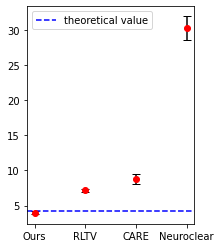

In [ ]:
original_volume   = np.zeros(30)
deconv_volume     = np.zeros(30)
neuroclear_volume = np.zeros(30)
care_volume       = np.zeros(30)
tenet_volume      = np.zeros(30)

for idx in range(30):
    original   = tifffile.imread(path_of(base, "fig4", "original"  , idx))[0]
    care       = tifffile.imread(path_of(base, "fig4", "care2", idx))
    deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , idx))
    neuroclear = tifffile.imread(path_of(base, "fig4", "neuroclear3_roi", idx))
    tenet      = tifffile.imread(path_of(base, "fig4", "tenet"     , idx))[0]

    # preprocess to 0 to 1
    original    = upsample3d(norm(original  , bit=16), scale=10)
    deconv      = upsample3d(deconv/deconv.max(), scale=10)
    neuroclear  = (norm(neuroclear, bit=16))
    care       /= care.max()
    tenet       = tenet

    original_volume  [idx] = np.sum((original   > 0.5) * 0.05 ** 3)
    deconv_volume    [idx] = np.sum((deconv     > 0.1) * 0.05 ** 3)
    neuroclear_volume[idx] = np.sum((neuroclear > 0.1) * 0.05 ** 3)
    care_volume      [idx] = np.sum((care       > 0.3) * 0.05 ** 3)
    tenet_volume     [idx] = np.sum((tenet      > 0.5) * 0.05 ** 3)

volumes_list = [
    tenet_volume     ,
    deconv_volume    ,
    care_volume      ,
    neuroclear_volume,
]

mus = np.zeros(4)
cis = np.zeros(4)
for i, volumes in enumerate(volumes_list):
    mu = volumes.mean()
    s2 = (volumes.var(ddof=1))
    ci95 = 2.045*((s2/30)**0.5)
    mus[i] = mu
    cis[i] = ci95

x = np.arange(len(mus))
fig, ax = plt.subplots(figsize=(3, 4))
ax.errorbar(x, mus,cis, fmt="ro", capsize=4, ecolor='black')
ax.set_xticks(x)
#ax.set_yticks(np.arange(3, 32))
ax.set_xticklabels(["Ours", "RLTV", "CARE", "Neuroclear"])
ax.axhline(y=4.187, color='b', linestyle='--', label='theoretical value')
plt.legend()
plt.tight_layout(pad=10)
plt.show()

In [63]:
print(mus, cis)

[ 4.0034      7.197125    8.80140833 30.33274167] [0.20181265 0.22355524 0.75416576 1.68371748]


In [89]:
tenet      = tifffile.imread(path_of(base, "fig4", "tenet"     , idx))[0]
print(tenet.max())
print(tenet.min())

0.99997115
3.1769465e-14


In [108]:
get_best_threshold(care[:, 64], bit=16)

0

(array([26472.,   593.,   513.,   533.,   499.,   475.,   705.,   510.,
          284.,   136.]),
 array([0.        , 0.08875415, 0.1775083 , 0.26626244, 0.3550166 ,
        0.44377074, 0.5325249 , 0.621279  , 0.7100332 , 0.79878736,
        0.8875415 ], dtype=float32),
 <BarContainer object of 10 artists>)

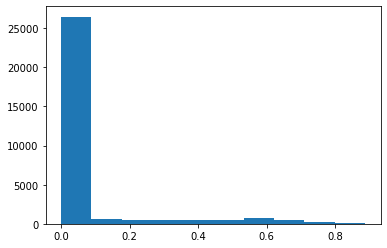

In [106]:
deconv     = tifffile.imread(path_of(base, "fig4", "deconv"    , 0))
deconv      = upsample3d(deconv/deconv.max(), scale=10)
deconv = np.clip(deconv, a_min=0,a_max=1)
plt.hist(care[:, 64].flatten(), bins=10)